In [1]:
import os
import sys
import h5py
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from sklearn import metrics

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14

from theme import colors

from src.dataset import StructuresDataset, collate_batch_features, select_by_sid, select_by_max_ba, select_by_interface_types
from src.data_encoding import encode_structure, encode_features, extract_topology, categ_to_resnames, resname_to_categ
from src.structure import data_to_structure, encode_bfactor
from src.structure_io import save_pdb, read_pdb
from src.scoring import bc_scoring, bc_score_names, nanmean

In [2]:
def setup_dataset(config_data, r_types_sel):
    # set up dataset
    dataset = Dataset("datasets/contacts_rr5A_64nn_8192.h5")

    # selected structures
    sids_sel = np.genfromtxt("datasets/subunits_validation_set.txt", dtype=np.dtype('U'))

    # filter dataset
    m = select_by_sid(dataset, sids_sel) # select by sids
    
    # data selection criteria
    m = select_by_sid(dataset, sids_sel) # select by sids
    m &= select_by_max_ba(dataset, config_data['max_ba'])  # select by max assembly count
    #m &= (dataset.sizes[:,0] <= config_data['max_size']) # select by max size
    m &= (dataset.sizes[:,1] >= config_data['min_num_res'])  # select by min size
    m &= select_by_interface_types(dataset, config_data['l_types'], np.concatenate(r_types_sel))  # select by interface type

    # update dataset selection
    dataset.update_mask(m)

    # set dataset types
    dataset.set_types(config_data['l_types'], config_data['r_types'])

    # debug print
    return dataset


def eval_model(model, dataset, ids):
    p_l, y_l = [], []
    with pt.no_grad():
        for i in tqdm(ids):
            # get data
            X, ids_topk, q, M, y = dataset[i]

            # pack data and setup sink (IMPORTANT)
            X, ids_topk, q, M = collate_batch_features([[X, ids_topk, q, M]])

            # run model
            z = model(X.to(device), ids_topk.to(device), q.to(device), M.float().to(device))

            # prediction
            p = pt.sigmoid(z)

            # categorical predictions
            pc = pt.cat([1.0 - pt.max(p, axis=1)[0].unsqueeze(1), p], axis=1).cpu()
            yc = pt.cat([1.0 - pt.any(y > 0.5, axis=1).float().unsqueeze(1), y], axis=1).cpu()

            # data
            p_l.append(pc)
            y_l.append(yc)
    
    return p_l, y_l

In [3]:
# model parameters
# R2
#save_path = "model/save/i_v2_4_2021-03-23_11-51"  # 85
#save_path = "model/save/i_v2_7_2021-05-21_17-33"  # 89
# R3
#save_path = "model/save/i_v3_0_2021-05-27_14-27"  # 89
# R4
#save_path = "model/save/i_v4_0_2021-09-07_11-20"  # 89
save_path = "model/save/i_v4_1_2021-09-07_11-21"  # 91

# select saved model
model_filepath = os.path.join(save_path, 'model_ckpt.pt')
#model_filepath = os.path.join(save_path, 'model.pt')

In [4]:
# add module to path
if save_path not in sys.path:
    sys.path.insert(0, save_path)
    
# load functions
from config import config_model, config_data
from data_handler import Dataset
from model import Model

In [5]:
# define device
device = pt.device("cuda")

# create model
model = Model(config_model)

# reload model
model.load_state_dict(pt.load(model_filepath, map_location=pt.device("cpu")))

# set model to inference
model = model.eval().to(device)

In [6]:
p_l, y_l = [], []
for i in range(len(config_data['r_types'])):
    # debug print
    print(config_data['r_types'][i])

    # load datasets
    dataset = setup_dataset(config_data, [config_data['r_types'][i]])
    print("dataset: {}".format(len(dataset)))

    # parameters
    N = min(len(dataset), 512)

    # run negative examples
    ids = np.arange(len(dataset))
    np.random.shuffle(ids)
    pi_l, yi_l = eval_model(model, dataset, ids[:N])
    
    # store evaluation results
    p_l.append(pi_l)
    y_l.append(yi_l)

['GLU', 'LEU', 'ALA', 'ASP', 'SER', 'VAL', 'GLY', 'THR', 'ARG', 'PHE', 'TYR', 'ILE', 'PRO', 'ASN', 'LYS', 'GLN', 'HIS', 'TRP', 'MET', 'CYS']
dataset: 32905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:57<00:00,  8.91it/s]


['DA', 'DT', 'DG', 'DC', 'A', 'U', 'G', 'C']
dataset: 391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.69it/s]


['MG', 'ZN', 'CL', 'CA', 'NA', 'MN', 'K', 'IOD', 'CD', 'CU', 'FE', 'NI', 'SR', 'BR', 'CO', 'HG']
dataset: 11952


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:01<00:00,  8.30it/s]


['SO4', 'NAG', 'PO4', 'EDO', 'ACT', 'MAN', 'HEM', 'FMT', 'BMA', 'ADP', 'FAD', 'NAD', 'NO3', 'GLC', 'ATP', 'NAP', 'BGC', 'GDP', 'FUC', 'FES', 'FMN', 'GAL', 'GTP', 'PLP', 'MLI', 'ANP', 'H4B', 'AMP', 'NDP', 'SAH', 'OXY']
dataset: 16376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:03<00:00,  8.12it/s]


['PLM', 'CLR', 'CDL', 'RET']
dataset: 161


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:30<00:00,  5.28it/s]


### Seaching interface

In [7]:
# parameters
class_names = ["protein", "DNA/RNA", "ion", "ligand", "lipid"]

# compute scores per class
scores = []
for i in range(len(y_l)):
    # extract class
    p = pt.cat(p_l[i], axis=0)[:,i+1]
    y = pt.cat(y_l[i], axis=0)[:,i+1]

    # compute scores
    s = bc_scoring(y.unsqueeze(1), p.unsqueeze(1)).squeeze().numpy()
    
    # compute F1 score
    f1 = metrics.f1_score(y.numpy().astype(int), p.numpy().round())
    
    # compute ratio of positives
    r = pt.mean(y)
    
    # store results
    scores.append(np.concatenate([s, [f1, r]]))
    
# pack data
scores = np.stack(scores).T

# make table
df = pd.DataFrame(data=np.round(scores,2), index=bc_score_names+['F1', 'r'], columns=class_names)

# save dataframe
df.to_csv("results/type_interface_search_scores.csv")

# display
display(df)

,protein,DNA/RNA,ion,ligand,lipid
acc,0.89,0.90,0.93,0.89,0.69
ppv,0.74,0.46,0.39,0.35,0.12
npv,0.92,0.96,0.98,0.97,0.98
tpr,0.64,0.63,0.64,0.61,0.72
tnr,0.95,0.93,0.95,0.91,0.69
mcc,0.62,0.48,0.46,0.41,0.20
auc,0.91,0.89,0.87,0.85,0.77
std,0.31,0.28,0.21,0.23,0.38
F1,0.68,0.53,0.48,0.44,0.21
r,0.19,0.09,0.05,0.07,0.06


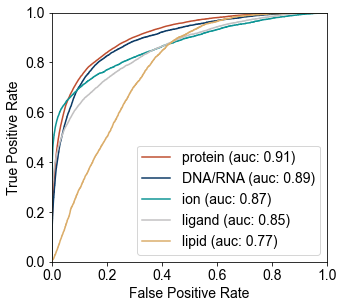

In [8]:
# parameters
class_names = ["protein", "DNA/RNA", "ion", "ligand", "lipid"]

# plot
plt.figure(figsize=(5,4.5))
for i in range(len(y_l)):
    # get labels and predictions for class
    yi = pt.cat(y_l[i], axis=0)[:,i+1]
    pi = pt.cat(p_l[i], axis=0)[:,i+1]

    # compute roc and roc auc
    fpr, tpr, _ = metrics.roc_curve(yi.numpy(), pi.numpy())
    auc = metrics.auc(fpr, tpr)
    
    # update plot
    plt.plot(fpr, tpr, '-', color=colors[i], label="{} (auc: {:.2f})".format(class_names[i], auc))
    
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.savefig("results/type_interface_search_roc_auc.svg")
plt.savefig("results/type_interface_search_roc_auc.png", dpi=300)
plt.show()

### Interface identification

In [9]:
# parameters
class_names = ["protein", "DNA/RNA", "ion", "ligand", "lipid"]

# pack results
P = pt.cat([pt.cat(p, axis=0) for p in p_l], axis=0)
Y = pt.cat([pt.cat(y, axis=0) for y in y_l], axis=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, axis=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = Yi.shape[1]
N = int(pt.min(pt.sum(Yi, axis=0)).item())
ids_unif = pt.from_numpy(np.concatenate([np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False) for i in range(n)]))

# compute scores for each class
scores = []
for i in range(n):
    # extract class
    p = Pi[ids_unif,i]
    y = Yi[ids_unif,i]

    # compute scores
    s = bc_scoring(y.unsqueeze(1), p.unsqueeze(1)).squeeze().numpy()
    
    # compute F1 score
    f1 = metrics.f1_score(y.numpy().astype(int), p.numpy().round())
    
    scores.append(np.concatenate([s, [f1]]))
    
# pack data
scores = np.stack(scores).T

# make table
df = pd.DataFrame(data=np.round(scores,2), index=bc_score_names+['F1'], columns=class_names)

# save dataframe
df.to_csv("results/type_interface_identification_scores.csv")

# display
display(df)

,protein,DNA/RNA,ion,ligand,lipid
acc,0.85,0.91,0.85,0.78,0.93
ppv,0.63,0.91,0.62,0.47,0.94
npv,0.91,0.92,0.91,0.89,0.93
tpr,0.64,0.63,0.65,0.60,0.72
tnr,0.91,0.98,0.90,0.83,0.99
mcc,0.55,0.71,0.54,0.39,0.78
auc,0.87,0.94,0.84,0.80,0.97
std,0.34,0.31,0.31,0.30,0.30
F1,0.64,0.75,0.64,0.53,0.81


3627


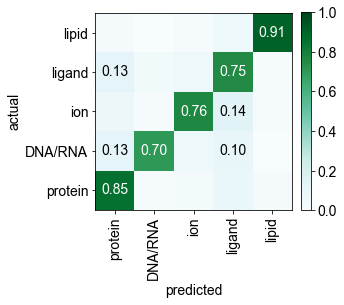

In [42]:
# pack results
P = pt.cat([pt.cat(p, axis=0) for p in p_l], axis=0)
Y = pt.cat([pt.cat(y, axis=0) for y in y_l], axis=0)

# select only residues at interface
m = pt.any(Y[:,1:] > 0.5, axis=1)
Pi = P[m,1:]
Yi = Y[m,1:]

# pick same sampling of all classes
n = Yi.shape[1]
N = int(pt.min(pt.sum(Yi, axis=0)).item())
ids_l = [pt.from_numpy(np.random.choice(pt.where(Yi[:,i] > 0.5)[0].numpy(), N, replace=False)) for i in range(n)]

# compute scores for each class
C = pt.zeros((n,n))
for i in range(n):
    ids = pt.argmax(Pi[ids_l[i]], axis=1)
    for j,k in zip(ids, ids_l[i]):
        C[i,j] += Pi[k,j].round()
        

# normalize score
H = (C / pt.sum(C, axis=1).unsqueeze(1)).numpy()
#H = (C / pt.sum(C, axis=0).unsqueeze(0)).numpy()

# plot
plt.figure(figsize=(5, 5))
plt.imshow(H, origin='lower', cmap='BuGn', vmin=0.0, vmax=1.0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(np.arange(n), class_names, rotation=90)
plt.yticks(np.arange(n), class_names)
for i in range(n):
    for j in range(n):
        v = H[i,j]
        if v > 0.1:
            plt.text(j,i,f"{v:.2f}", ha='center', va='center', color=[np.round(v-0.1)]*3)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.tight_layout()
plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.svg")
plt.savefig("results/type_interface_identification_most_confident_confusion_matrix.png", dpi=300)
plt.show()